list of techniques [here](https://blog.floydhub.com/ten-techniques-from-fast-ai/)

In [25]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
import copy

%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [27]:
transform = transforms.Compose([
#                                    transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
# mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# mnist_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
# data_loader_train = DataLoader(mnist_trainset, 64, shuffle=True, num_workers=8)
# data_loader_test = DataLoader(mnist_testset, 64, shuffle=True, num_workers=8)

Files already downloaded and verified


In [59]:
temp_raw_data_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
class TempDataSet(Dataset):
    def __getitem__(self, index):
        return temp_set[index]
    def __len__(self):
        return 6
temp_data_set = TempDataSet()
data_loader_train = DataLoader(temp_data_set, 3, shuffle=True, num_workers=8)
data_loader_test = DataLoader(temp_data_set, 3, shuffle=True, num_workers=8)

Files already downloaded and verified


In [28]:
import RestNet
model = RestNet.ResNet18().to(device)
criterion = F.cross_entropy

In [52]:
# model = torchvision.models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

### Find learning rate

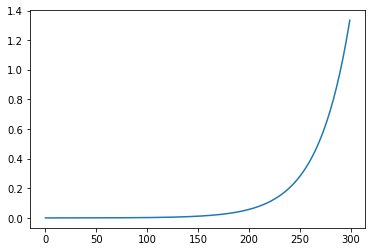

In [7]:
import math
lrs = []
for i in [x for x in range(300)]:
    lr = math.pow(1.1, i/3) / 10000
    lrs.append(lr)
plt.plot(lrs)

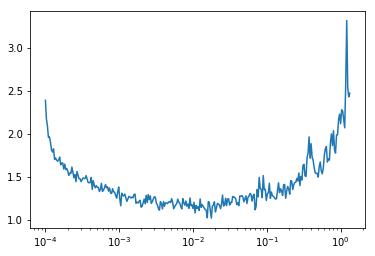

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
model.train()
def is_running():
    return len(losses) < len(lrs)
count = 0
batch_num = 10
while is_running():
    for i, (data, target) in enumerate(data_loader_train):
        if count == 0:
            loss_accumulate = 0
            for param_group in optimizer.param_groups:
                param_group['lr'] = lrs[len(losses)]

        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss_accumulate += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if count == batch_num:
            losses.append(loss_accumulate/batch_num)
            count = -1
        if not is_running(): break
        count += 1
        
plt.semilogx(lrs, losses)

### Learning Rates [Choose one]
1. Different LR [worse] (maybe we have to use log scale)

In [60]:
lr = 0.001
num_children = len([c for c in model.children()])
param_groups = []
for i, child in enumerate(model.children()):
    denorm = num_children-i
    param_groups.append({
        'params': child.parameters(), 'lr': lr/denorm
    })
optimizer = optim.Adam(param_groups, lr=0.001, weight_decay=0.0) #weight_decay (L2 regularization) makes thing worse

In [61]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.00014285714285714287
0.00016666666666666666
0.0002
0.00025
0.0003333333333333333
0.0005
0.001


2. Static Learning Rate

In [76]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train

In [189]:
from typing import Callable
class Callback:
    def iterate(self, loss, output, target): pass
    def done(self, phase, num_data): pass
    def is_done(self): pass
    
class FitTracker(Callback):
    def __init__(self):
        super().__init__()
        self.total_loss = 0
        self.total_correct = 0
        
    def iterate(self, loss, output, target):
        # ------ find correct ----------
        # max of dimension 1, keepdim, and [0] is value / [1] is index (we need only index)
        pred = output.max(1)[1] # get the index of the max log-probability
        correct = pred.eq(target).sum().item()
        # ------------------------------
        self.total_loss += loss.item()
        self.total_correct += correct
        
    def done(self, phase, num_data):
        epoch_loss = self.total_loss / num_data*100
        epoch_acc = self.total_correct / num_data*100
        print('   [{}] Average loss: {:.4f}, acc: {:.2f}%'.format(phase, epoch_loss, epoch_acc))
        self.total_loss = 0
        self.total_correct = 0
        
class LRFinder(Callback):
    def __init__(self, start_lr, end_lr, num_it, optimizer, num_batch=10):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_it = num_it
        self.optimizer = optimizer
        self.num_batch = num_batch
        
        self.losses = []
        self.total_loss = 0
        self.lrs = []
        self.count = 0
        
    def annealing_exp(self, start:float, end:float, pct:float)->float:
        "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
        return start * (end/start) ** pct
    
    def update_lr(self):
        lr = self.annealing_exp(self.start_lr, self.end_lr, len(self.lrs)/self.num_it)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr
    
    def iterate(self, loss, output, target):
        self.total_loss += loss.item()
        self.count += 1
        if self.count == self.num_batch:
            self.lrs.append(self.update_lr())
            self.losses.append(self.total_loss/self.num_batch)
            self.count = 0
            self.total_loss =0
            
    def is_done(self): return len(self.losses)>self.num_it
        
class Learner:
    
    def __init__(self, data_loader_train, data_loader_test, model, scheduler, criterion):
        self.data_loader_train = data_loader_train
        self.data_loader_test  = data_loader_test
        self.model             = model
        self.scheduler         = scheduler
        self.criterion         = criterion

    def _run_model(self, phase, optimizer, callback:Callable=None):
        running_correct = 0
        running_loss = 0
        if phase=='train':
            if self.scheduler: self.scheduler.step()
            model.train()
            data_loader = self.data_loader_train
        else:
            model.eval() # to tell model to adjust to test phase (eg. no dropout)
            data_loader = self.data_loader_test
            
        with torch.set_grad_enabled(phase=='train'):
            for data in data_loader:
                data, target = (i.to(device) for i in data)
                output = self.model(data)
                loss = self.criterion(output, target)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                if callback: 
                    callback.iterate(loss, output, target)
                    if callback.is_done(): break
                
                
        if callback: callback.done(phase, len(data_loader.dataset))
    
    def fit(self, lr:float=0.003, num_epochs:int=25)->None:
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        fit_tracker = FitTracker()
        for i in range(num_epochs):
            print(f'---- epoch:{i} ------')
            self._run_model('train', optimizer, fit_tracker)
            self._run_model('test', optimizer, fit_tracker)
            
    def lr_find(self, start_lr:float=1e-7, end_lr:float=10, num_it:int=100)->None:
        optimizer = optim.Adam(self.model.parameters(), lr=start_lr)
        lr_finder = LRFinder(start_lr, end_lr, num_it, optimizer)
        while True:
            self._run_model('train', optimizer, lr_finder)
            if lr_finder.is_done(): break
        plt.semilogx(lr_finder.lrs, lr_finder.losses)

learner = Learner(data_loader_train, data_loader_test, model, None, criterion)
learner.fit(0.003, 3)
# learner.lr_find(1e-4, 1)

self.lrs: 0
self.lrs: 0
self.lrs: 0
self.lrs: 0
self.lrs: 0
self.lrs: 0
self.lrs: 0
self.lrs: 0
self.lrs: 0
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 1
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 2
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 3
self.lrs: 4
self.lrs: 4
self.lrs: 4
self.lrs: 4
self.lrs: 4
self.lrs: 4
self.lrs: 4
self.lrs: 4
self.lrs: 4
self.lrs: 4


Traceback (most recent call last):
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connectio

KeyboardInterrupt: 

with random rotate+zoom : train:100, test 83.31

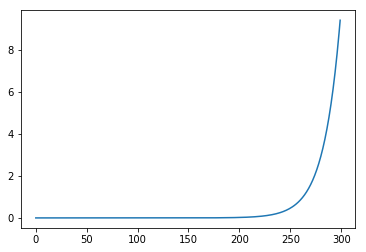

In [148]:
def annealing_exp(start:float, end:float, pct:float)->float:
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start * (end/start) ** pct
y = [annealing_exp(1e-7, 10, i/300) for i in range(300)]
plt.plot(y)